# Heart Rate Synchronization - Data Exploration
 
This notebook explores heart rate and audio data for the Heart Rate Synchronization project.


Participant 1 Heart Rate Data:
   timestamp  heart_rate
0        0.0   70.201228
1        1.0   70.662887
2        2.0   70.772956
3        3.0   70.783374
4        4.0   71.282994

Participant 2 Heart Rate Data:
   timestamp  heart_rate
0        0.0   75.201228
1        1.0   75.662887
2        2.0   75.772956
3        3.0   75.783374
4        4.0   76.282994


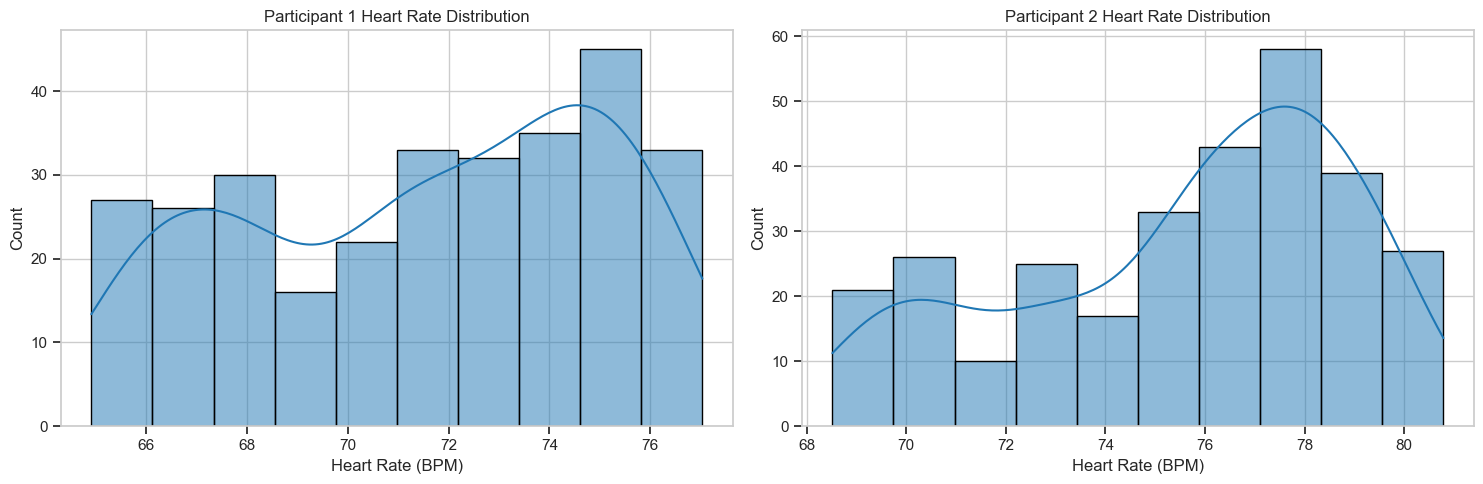

       Participant 1  Participant 2
count     299.000000     299.000000
mean       71.529353      75.581193
std         3.556481       3.312016
min        64.917670      68.514945
25%        68.167246      73.056057
50%        72.009725      76.282994
75%        74.663392      78.060632
max        77.031369      80.789914


In [10]:

# %%
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from scipy import stats, signal
import os
import sys

# Add project root to path to enable imports
sys.path.append('..')

# Import project modules
from src.preprocess import preprocess_heart_rate, preprocess_audio
from config import PROCESSING_CONFIG

# Set plotting styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('notebook')
# %matplotlib inline - This will work when converted to a notebook

# %% [markdown]
# ## 1. Load and Explore Heart Rate Data

# %%
# Define data paths
# Replace with your actual data paths
hr_file1 = '../data/raw/participant1_hr.csv'
hr_file2 = '../data/raw/participant2_hr.csv'

# Check if files exist
if os.path.exists(hr_file1) and os.path.exists(hr_file2):
    # Load heart rate data
    hr_data1 = pd.read_csv(hr_file1)
    hr_data2 = pd.read_csv(hr_file2)
    
    print("Participant 1 Heart Rate Data:")
    print(hr_data1.head())
    print("\nParticipant 2 Heart Rate Data:")
    print(hr_data2.head())
else:
    print("Heart rate data files not found. Please update the file paths.")

# %% [markdown]
# ### 1.1 Explore Heart Rate Data Distribution

# %%
# Check if files exist before proceeding
if os.path.exists(hr_file1) and os.path.exists(hr_file2):
    # Preprocess heart rate data
    processed_hr1 = preprocess_heart_rate(hr_data1, 'p1')
    processed_hr2 = preprocess_heart_rate(hr_data2, 'p2')
    
    # Plot histograms of heart rates
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    sns.histplot(processed_hr1['heart_rate'], kde=True, ax=axes[0])
    axes[0].set_title('Participant 1 Heart Rate Distribution')
    axes[0].set_xlabel('Heart Rate (BPM)')
    
    sns.histplot(processed_hr2['heart_rate'], kde=True, ax=axes[1])
    axes[1].set_title('Participant 2 Heart Rate Distribution')
    axes[1].set_xlabel('Heart Rate (BPM)')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate basic statistics
    stats1 = processed_hr1['heart_rate'].describe()
    stats2 = processed_hr2['heart_rate'].describe()
    
    stats_df = pd.concat([stats1, stats2], axis=1)
    stats_df.columns = ['Participant 1', 'Participant 2']
    print(stats_df)



### 1.2 Plot Heart Rate Time Series


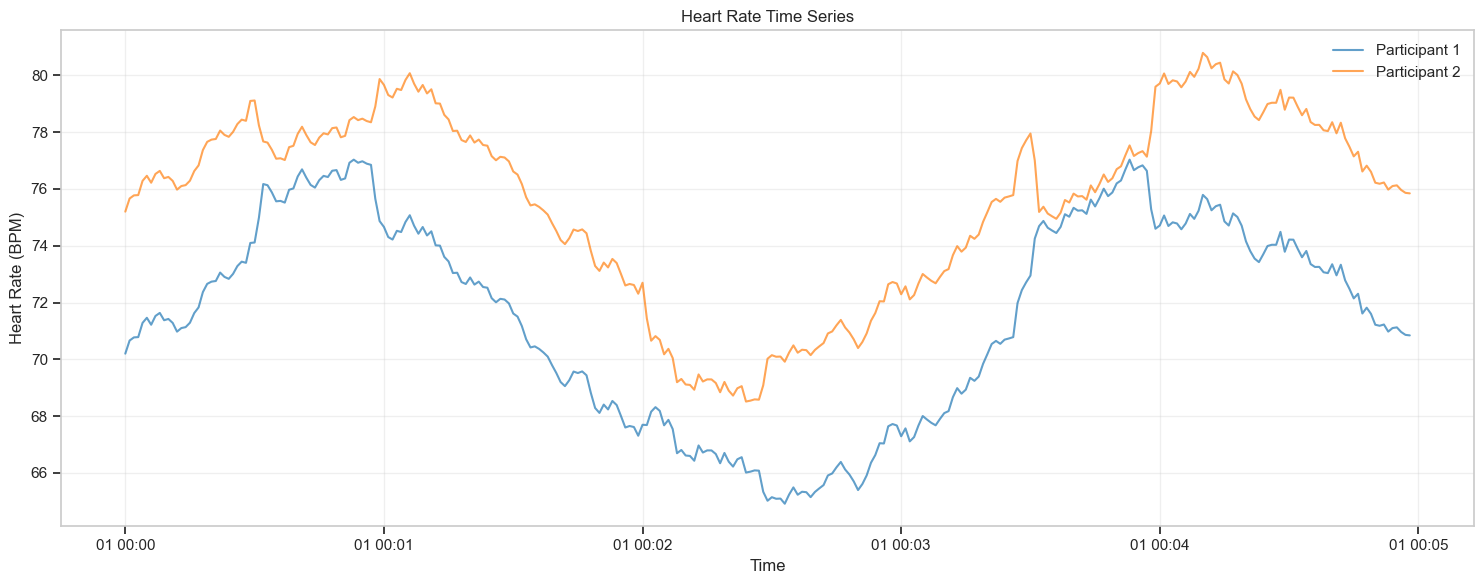

Audio sample rate: 44100 Hz
Audio duration: 300.00 seconds
Number of samples: 13230000


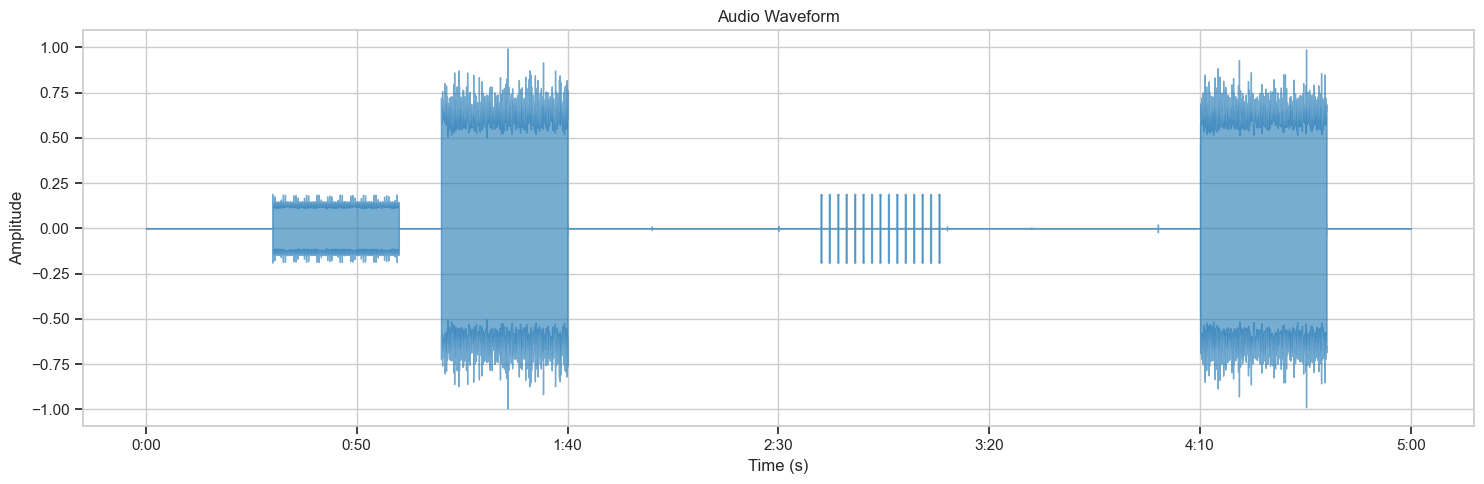

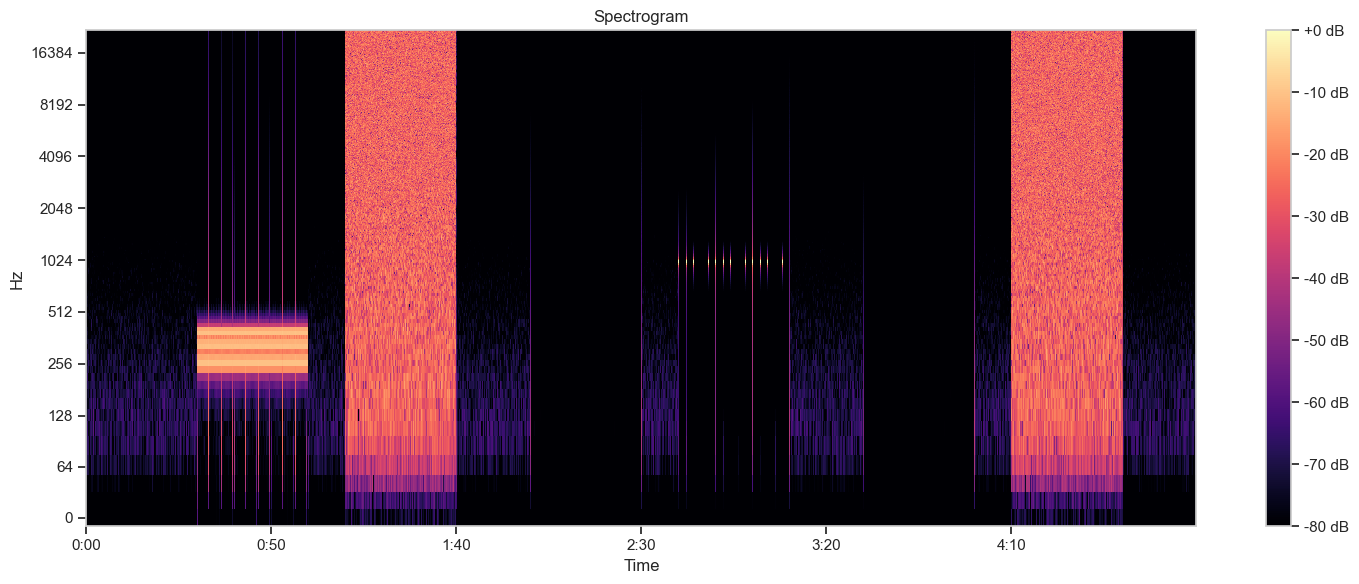

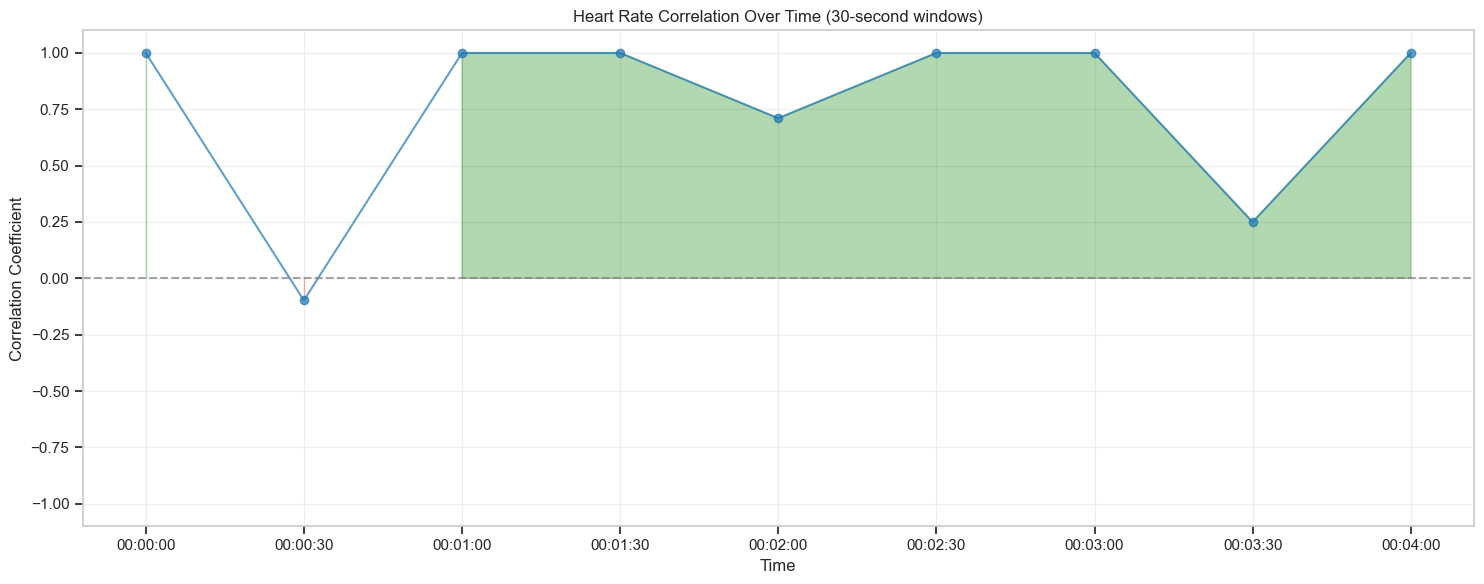

Average correlation: 0.762
Median correlation: 1.000
Standard deviation: 0.386
Proportion of positive correlations: 0.89


In [11]:

# %%
# Check if files exist before proceeding
if os.path.exists(hr_file1) and os.path.exists(hr_file2):
    # Plot heart rate time series
    plt.figure(figsize=(15, 6))
    
    # Convert timestamps to datetime for better x-axis labels
    processed_hr1['datetime'] = pd.to_datetime(processed_hr1['timestamp'], unit='s')
    processed_hr2['datetime'] = pd.to_datetime(processed_hr2['timestamp'], unit='s')
    
    plt.plot(processed_hr1['datetime'], processed_hr1['heart_rate'], label='Participant 1', alpha=0.7)
    plt.plot(processed_hr2['datetime'], processed_hr2['heart_rate'], label='Participant 2', alpha=0.7)
    
    plt.xlabel('Time')
    plt.ylabel('Heart Rate (BPM)')
    plt.title('Heart Rate Time Series')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# %% [markdown]
# ## 2. Load and Explore Audio Data

# %%
# Define audio file path
# Replace with your actual audio path
audio_file = '../data/raw/session_audio.wav'

# Check if file exists
if os.path.exists(audio_file):
    # Load and preprocess audio
    audio_data, sr = preprocess_audio(audio_file)
    
    print(f"Audio sample rate: {sr} Hz")
    print(f"Audio duration: {len(audio_data) / sr:.2f} seconds")
    print(f"Number of samples: {len(audio_data)}")
else:
    print("Audio file not found. Please update the file path.")

# %% [markdown]
# ### 2.1 Visualize Audio Waveform

# %%
# Check if file exists before proceeding
if os.path.exists(audio_file):
    # Plot audio waveform
    plt.figure(figsize=(15, 5))
    librosa.display.waveshow(audio_data, sr=sr, alpha=0.6)
    plt.title('Audio Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

# %% [markdown]
# ### 2.2 Visualize Spectrogram

# %%
# Check if file exists before proceeding
if os.path.exists(audio_file):
    # Plot spectrogram
    plt.figure(figsize=(15, 6))
    
    # Compute spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data)), ref=np.max)
    
    # Plot spectrogram
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.tight_layout()
    plt.show()

# %% [markdown]
# ## 3. Preliminary Synchronization Analysis

# %%
# Check if both heart rate and audio files exist
if os.path.exists(hr_file1) and os.path.exists(hr_file2) and os.path.exists(audio_file):
    # Calculate correlation between heart rates
    # First, we need to align heart rate data on the same time grid
    
    # Find common time range
    start_time = max(processed_hr1['timestamp'].min(), processed_hr2['timestamp'].min())
    end_time = min(processed_hr1['timestamp'].max(), processed_hr2['timestamp'].max())
    
    # Filter data to common time range
    common_hr1 = processed_hr1[(processed_hr1['timestamp'] >= start_time) & 
                               (processed_hr1['timestamp'] <= end_time)]
    common_hr2 = processed_hr2[(processed_hr2['timestamp'] >= start_time) & 
                               (processed_hr2['timestamp'] <= end_time)]
    
    # Create time windows for correlation analysis (30-second windows)
    window_size = 30  # seconds
    window_correlations = []
    window_starts = []
    
    for window_start in range(int(start_time), int(end_time - window_size), window_size):
        window_end = window_start + window_size
        
        # Get heart rate data for current window
        win_hr1 = common_hr1[(common_hr1['timestamp'] >= window_start) & 
                             (common_hr1['timestamp'] < window_end)]
        win_hr2 = common_hr2[(common_hr2['timestamp'] >= window_start) & 
                             (common_hr2['timestamp'] < window_end)]
        
        # Compute correlation if enough data points
        if len(win_hr1) >= 10 and len(win_hr2) >= 10:
            # Need to align on common timestamps
            merged = pd.merge(win_hr1, win_hr2, on='timestamp', suffixes=('_p1', '_p2'))
            
            if len(merged) >= 5:  # Minimum 5 points for meaningful correlation
                corr, _ = stats.pearsonr(merged['heart_rate_p1'], merged['heart_rate_p2'])
                window_correlations.append(corr)
                window_starts.append(window_start)
    
    # Plot correlations over time
    plt.figure(figsize=(15, 6))
    
    # Convert timestamps to datetime for better x-axis labels
    window_times = pd.to_datetime(window_starts, unit='s')
    
    plt.plot(window_times, window_correlations, 'o-', alpha=0.7)
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
    
    # Add regions to highlight positive/negative correlations
    plt.fill_between(window_times, window_correlations, 0, 
                     where=(np.array(window_correlations) > 0), 
                     alpha=0.3, color='green')
    plt.fill_between(window_times, window_correlations, 0, 
                     where=(np.array(window_correlations) < 0), 
                     alpha=0.3, color='red')
    
    plt.xlabel('Time')
    plt.ylabel('Correlation Coefficient')
    plt.title('Heart Rate Correlation Over Time (30-second windows)')
    plt.ylim(-1.1, 1.1)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"Average correlation: {np.mean(window_correlations):.3f}")
    print(f"Median correlation: {np.median(window_correlations):.3f}")
    print(f"Standard deviation: {np.std(window_correlations):.3f}")
    print(f"Proportion of positive correlations: {np.mean(np.array(window_correlations) > 0):.2f}")



## 4. Next Steps

After this initial exploration, the next steps would be:

1. Extract features from heart rate and audio data
2. Classify audio contexts
3. Analyze synchronization in relation to audio contexts
4. Perform statistical testing and validation

These steps are implemented in the main analysis pipeline. Run the main script to perform the full analysis:

```
python ../main.py --hr1 ../data/raw/participant1_hr.csv --hr2 ../data/raw/participant2_hr.csv --audio ../data/raw/session_audio.wav
``` 